# Projeto #1 - Mineração de agrupamentos

<p style='text-align: justify;'><font size=3.>Análise de acidentes nas rodovias federais brasileira entre 2007 e 2021.</font></p>

### Bibliotecas básicas e outros imports

In [1]:
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from pyclustertend import hopkins
from sklearn.preprocessing import StandardScaler

%run modules/text.py

%matplotlib inline
plt.rcParams['font.family'] = 'Arial, Helvetica, sans-serif'

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

### Carregamento dos dados

In [2]:
df = pd.read_csv('dataset/cluster_acidentes_rodovias_brasileiras_2007_a_2021.csv', low_memory=False, encoding='utf-8')
print(f'Linhas: {df.shape[0]} | Coluna:  {df.shape[1]}')
df.head(1)

Linhas: 1707393 | Coluna:  27


,id,dia_semana,uf,br,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,tipo_veiculo,tipo_envolvido,estado_fisico,idade,sexo,data,mes,ano,tipo_acidente_agrupado,fase_dia_agrupado,dia_semana_agrupado,condicao_metereologica_agrupado,porte_veiculo
0,83123216.0,quarta,SC,101,Balneario Camboriu,nao guardar distancia de seguranca,colisao traseira,sem vitimas,plena noite,decrescente,chuva,simples,reta,urbano,automovel,condutor,ileso,29,masculino,2014-01-01,1,2014,colisão,noite,dia útil,tempo ruim,pequeno porte


### Categorização da variável idade

> <p style='text-align: justify;'><font size=2.85>Categorização realizada de acordo com o estatuto da criança e adolescente (ECA).</font></p>

| faixa | categoria |
| --- | --- |
| 0-11 | criança |
| 12-17  | adolescente |
| 18-29 | jovem |
| 30-59 | adulto |
| acima de 60 | idoso |

In [3]:
labels = ['criança', 'adolescente', 'jovem', 'adulto', 'idoso']
classes = [0, 11, 17, 29, 59, 99]
df['faixa_etaria'] = pd.cut(x=df['idade'], bins=classes, labels=labels, include_lowest=True)

### Seleção de features

In [4]:
colunas = [
    'fase_dia_agrupado',
    'tipo_acidente',
    'causa_acidente',
    'condicao_metereologica',
    'tracado_via',
    'classificacao_acidente',
    'dia_semana',
    'tipo_pista',
    'porte_veiculo',
]

dados = df[colunas]
dados.head(1)

,fase_dia_agrupado,tipo_acidente,causa_acidente,condicao_metereologica,tracado_via,classificacao_acidente,dia_semana,tipo_pista,porte_veiculo
0,noite,colisao traseira,nao guardar distancia de seguranca,chuva,reta,sem vitimas,quarta,simples,pequeno porte


### Conversão para valores numéricos

In [5]:
le = LabelEncoder()
dados_copy = pd.DataFrame()
for col in dados.columns:
    dados_copy[col+'_encoder'] = le.fit_transform(dados[col].astype(str))

### Normalização dos dados

In [6]:
norm = Normalizer(norm='l2')
scaled = norm.fit_transform(dados_copy)

### Tendência de agrupamento - Estatística de Hopkins

<p style='text-align: justify;'><font size=2.85>H⁰: conjunto de dados é uniformemente distribuído e não contém clusters significativos.</font></p>

<p style='text-align: justify;'><font size=2.85>H¹: conjunto de dados não está uniformemente distribuído e contém clusters significativos.</font></p>

> <p style='text-align: justify;'><font size=2.85>Se H < 0.5, então não rejeita H⁰, pois é improvável que o conjunto tenha clusters estatisticamente significativos. Se o valor da estatística de Hopkins for próximo a 1, então podemos rejeitar a H⁰ e concluir que o conjunto de dados é significativamente um dado agrupável.</font></p>

In [7]:
scaled = pd.DataFrame(scaled)
scaled.columns = dados_copy.columns

stats = []
for i in range(0, 1025):
    sample = dados_copy.sample(n=500, replace=False)
    stats.append(hopkins(sample, sample.shape[0]))
print(f'Estatística de hopkins: {np.mean(stats).round(2)} +/- {np.std(stats).round(2)}')

Estatística de hopkins: 0.31 +/- 0.01


<p style='text-align: justify;'><font size=2.85>Pelo que podemos perceber pela estatística de hopkins, é improvável que esse conjunto de dados seja agrupável, ou seja, tenha clusters significativos. Nesse caso, a clusterização não é a técnica ideal para lidar com esse problema, mas para fins didáticos seguiremos com as análises.</font></p>

### Mineração de agrupamento

Método Elbow (cotovelo)

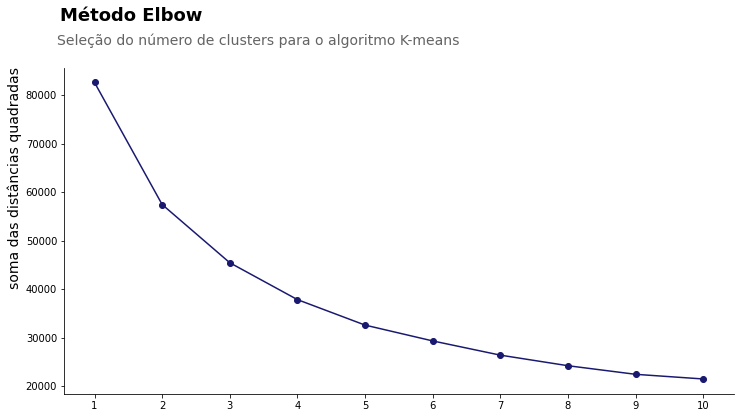

In [8]:
inertias = []
ks = range(1, 11)

for k in ks:
    model = KMeans(n_clusters=k, init='k-means++', random_state=42)
    model.fit(scaled)
    inertias.append(model.inertia_)
    

suptitle = 'Método Elbow'
title = 'Seleção do número de clusters para o algoritmo K-means'

plt.figure(figsize=(12, 6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(ks, inertias, '-o', color='#191970')
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.xlabel(None)
plt.ylabel('soma das distâncias quadradas', fontsize=14, horizontalalignment='left', y=0.32)
plt.xticks(ks)
plt.grid(False)
plt.show()

Coeficiente de Silhouette

> <p style='text-align: justify;'><font size=2.85>É uma medida de quão semelhante um ponto de dados é dentro do cluster (coesão) em comparação com outros clusters (separação). O melhor valor é 1 e o pior valor é -1. Valores próximos a 0 indicam clusters sobrepostos. Valores negativos geralmente indicam que uma amostra foi atribuída ao cluster errado, pois um cluster diferente é mais semelhante.</font></p>

Para n_clusters = 2 a média do silhouette_score é : 0.5207287977268694
Para n_clusters = 3 a média do silhouette_score é : 0.5351882784915003
Para n_clusters = 4 a média do silhouette_score é : 0.3140714673105126
Para n_clusters = 5 a média do silhouette_score é : 0.27341211368336504


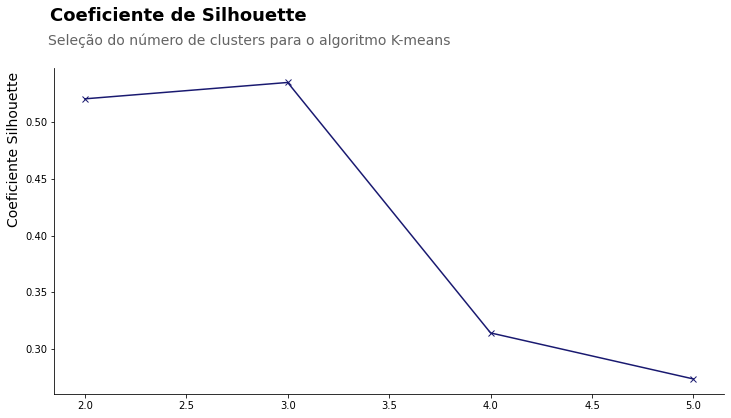

In [9]:
randomized = dados_copy.iloc[np.random.permutation(dados_copy.index)].reset_index(drop=True)
sample = randomized.sample(n=100000)
X = norm.fit_transform(sample)

range_n_clusters = range(2, 6)
silhouette_avg = []

for k in range_n_clusters:
    model = KMeans(n_clusters=k, init='k-means++', random_state=0)
    cluster_labels = model.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_avg.append(score)
    print('Para n_clusters =', k, 'a média do silhouette_score é :', score)


suptitle = 'Coeficiente de Silhouette'
title = 'Seleção do número de clusters para o algoritmo K-means'

plt.figure(figsize=(12, 6))
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.plot(range_n_clusters, silhouette_avg, 'bx-', color='#191970')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel(None)
plt.ylabel('Coeficiente Silhouette', fontsize=14, horizontalalignment='left', y=0.51) 
plt.grid(False)
plt.show()

<p style='text-align: justify;'><font size=2.85>A maior média do coeficiente de silhouette é 0.53 para três grupos. Esse valor é um indicativo da existência de clusters sobrepostos. Um valor baixo já era esperado, uma vez que na análise anterior percebemos que os dados não são agrupáveis.</font></p>

Agrupamento

In [10]:
kmeans= KMeans(n_clusters=3, init='k-means++', random_state=0).fit(scaled)
dados['cluster'] = kmeans.labels_

### Análise do agrupamento

In [11]:
print(dados['cluster'].value_counts())

0    1475185
1     194348
2      37860
Name: cluster, dtype: int64


Cluster 1

In [12]:
cluster_um = dados.query('cluster==0')
for col in cluster_um:
    print(f'Coluna {col}: {cluster_um[col].value_counts().index[0]}')

Coluna fase_dia_agrupado: dia
Coluna tipo_acidente: colisao traseira
Coluna causa_acidente: falta de atencao
Coluna condicao_metereologica: ceu claro
Coluna tracado_via: reta
Coluna classificacao_acidente: sem vitimas
Coluna dia_semana: sexta
Coluna tipo_pista: simples
Coluna porte_veiculo: pequeno porte
Coluna cluster: 0


Cluster 2

In [13]:
cluster_dois = dados.query('cluster==1')
for col in cluster_dois:
    print(f'Coluna {col}: {cluster_dois[col].value_counts().index[0]}')

Coluna fase_dia_agrupado: dia
Coluna tipo_acidente: saida de pista
Coluna causa_acidente: falta de atencao
Coluna condicao_metereologica: ceu claro
Coluna tracado_via: reta
Coluna classificacao_acidente: com vitimas feridas
Coluna dia_semana: domingo
Coluna tipo_pista: simples
Coluna porte_veiculo: pequeno porte
Coluna cluster: 1


Cluster 3

In [14]:
cluster_tres = dados.query('cluster==2')
for col in cluster_tres:
    print(f'Coluna {col}: {cluster_tres[col].value_counts().index[0]}')

Coluna fase_dia_agrupado: noite
Coluna tipo_acidente: atropelamento de animal
Coluna causa_acidente: animais na pista
Coluna condicao_metereologica: ceu claro
Coluna tracado_via: reta
Coluna classificacao_acidente: sem vitimas
Coluna dia_semana: sexta
Coluna tipo_pista: simples
Coluna porte_veiculo: pequeno porte
Coluna cluster: 2
